In [1]:
import albumentations as A
import cv2
import torch
import random
import numpy as np

from matplotlib import pyplot as plt
from pathlib import Path

### Geometrical Transformations

In [2]:
image = cv2.imread("images/corgi.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
transform = A.Compose([
    A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
])

transformed = transform(image=image)

In [4]:
transformed.keys()

dict_keys(['image'])

In [5]:
random.seed(0)
images = [transform(image=image)['image'] for _ in range(3)]
images.insert(0, image)

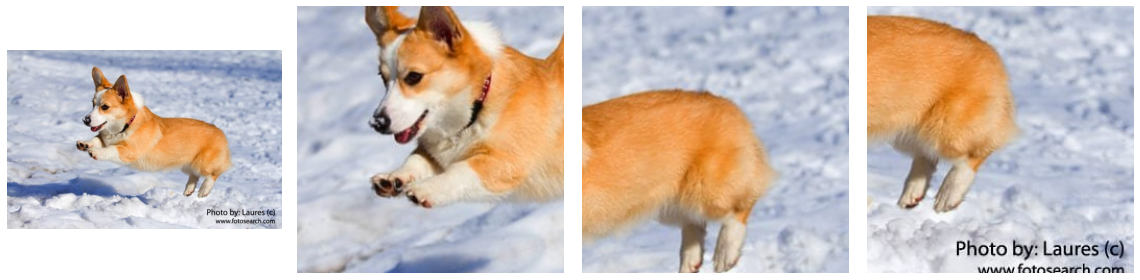

In [6]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axs[i].imshow(images[i])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Color Transformations

In [7]:
identity = A.Compose([
    A.NoOp()
])

light = A.Compose([
    A.RandomBrightnessContrast(p=1),
    A.RandomGamma(p=1),
    A.CLAHE(p=1),
], p=1)

medium = A.Compose([
    A.CLAHE(p=1),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=1),
], p=1)

strong = A.Compose([
    A.ChannelShuffle(p=1),
], p=1)

In [8]:
random.seed(0)
images = [t(image=image)['image'] for t in [identity, light, medium, strong]]

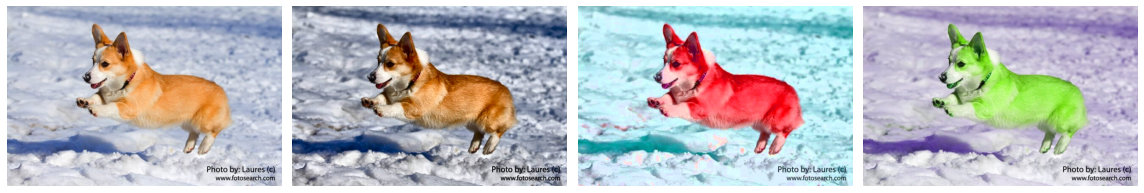

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i in range(4):
    axs[i].imshow(images[i])
    axs[i].axis('off')
plt.tight_layout()
plt.show()

### Domain Adoptations

In [10]:
def show(image):
    plt.figure(figsize=(16, 9))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

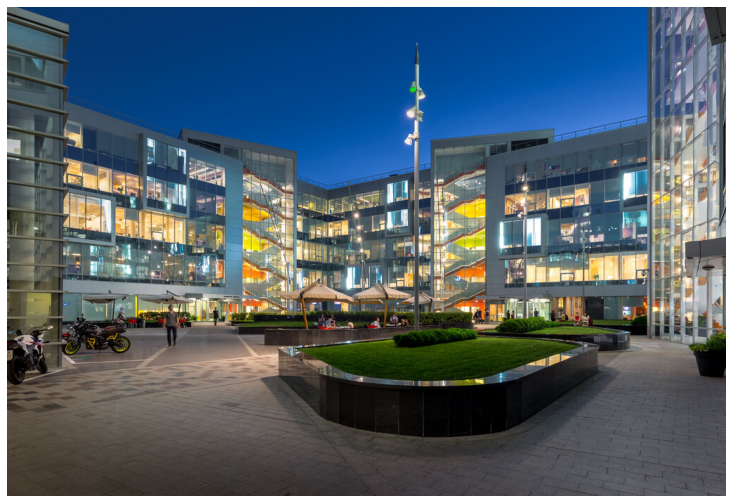

In [11]:
image = cv2.imread("images/weather_example.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
show(image)

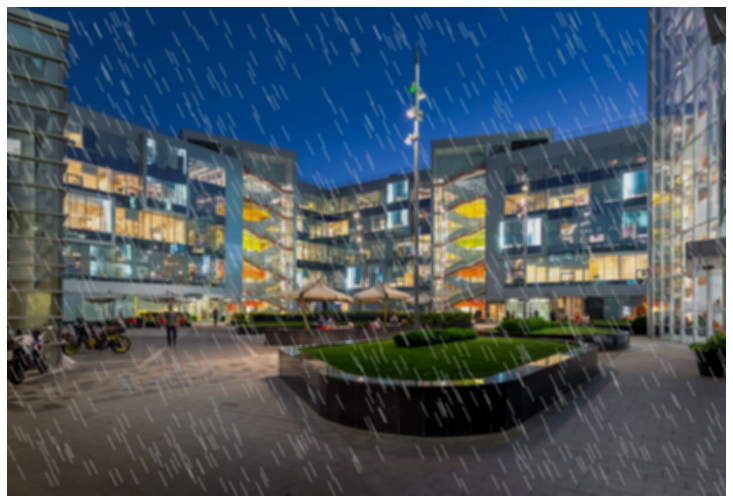

In [12]:
transform = A.Compose([
    A.RandomRain(brightness_coefficient=0.9, drop_width=1, blur_value=5, p=1)
])

random.seed(0)
transformed = transform(image=image)
show(transformed['image'])

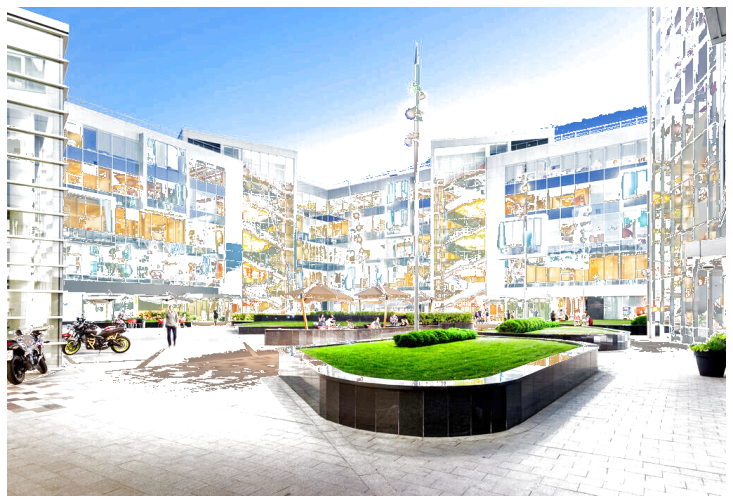

In [13]:
transform = A.Compose([
    A.RandomSnow(brightness_coeff=3.0, snow_point_lower=0.3, snow_point_upper=0.5, p=1)
])

random.seed(0)
transformed = transform(image=image)
show(transformed['image'])

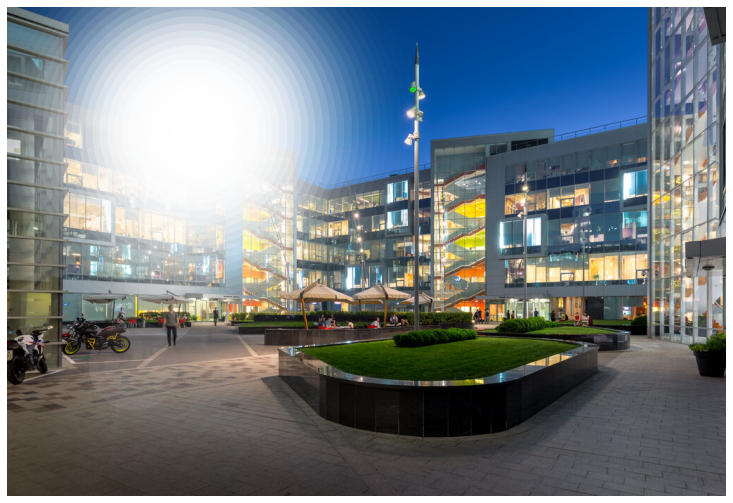

In [14]:
transform = A.Compose([
    A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=1)
])

random.seed(0)
transformed = transform(image=image)
show(transformed['image'])

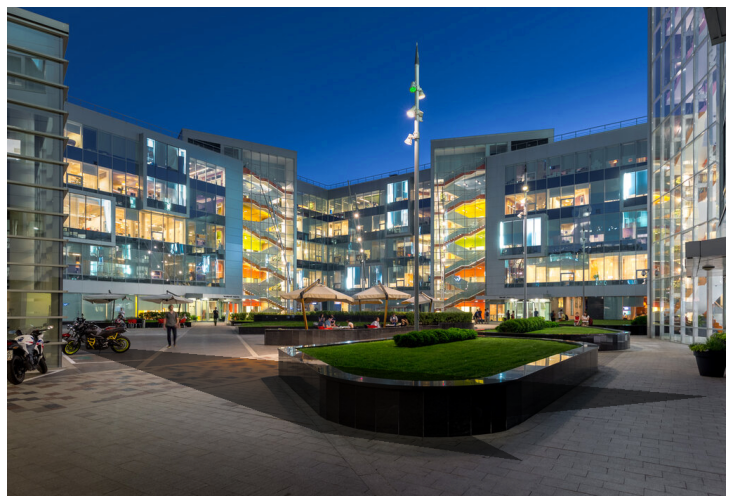

In [15]:
transform = A.Compose([
    A.RandomShadow(num_shadows_lower=1, num_shadows_upper=1, shadow_dimension=5, shadow_roi=(0, 0.5, 1, 1), p=1)
])

random.seed(0)
transformed = transform(image=image)
show(transformed['image'])

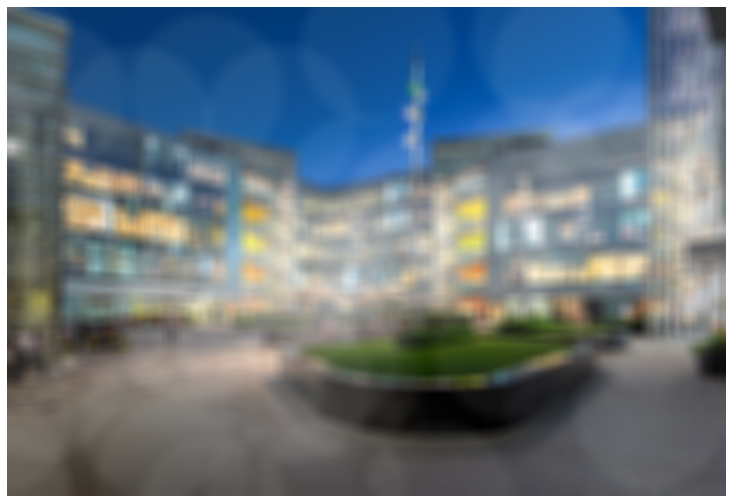

In [16]:
transform = A.Compose([
    A.RandomFog(fog_coef_lower=0.6, fog_coef_upper=0.7, alpha_coef=0.1, p=1)
])

random.seed(0)
transformed = transform(image=image)
show(transformed['image'])

### Transforming Masks and Bounding Boxes

In [17]:
image = cv2.imread('images/dsb2018_image.png')
masks = [
    cv2.imread(str(mask), cv2.IMREAD_GRAYSCALE)
    for mask in Path('images/dsb2018_masks').glob('*')
]
bboxes = [
    cv2.boundingRect(cv2.findNonZero(mask))
    for mask in masks
]

categories = [0] * len(bboxes)
label_image = np.zeros_like(masks[0])
for i, mask in enumerate(masks):
    label_image += (mask > 0).astype(np.uint8) * i

In [18]:
transform = A.Compose([
    A.RGBShift(),
    A.InvertImg(),
    A.Blur(),
    A.GaussNoise(),
    A.Flip(),
    A.RandomRotate90(),
    A.RandomSizedCrop((512 - 100, 512 + 100), 512, 512),
], bbox_params={'format':'coco', 'min_area': 1, 'min_visibility': 0.5, 'label_fields': ['category_id']}, p=1)

In [19]:
def visualize_bbox(img, bbox, color=(255, 0, 0), thickness=2, **kwargs):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img

In [20]:
random.seed(0)

transformed = transform(image=image, mask=label_image, bboxes=bboxes, category_id=categories)
t_image, t_label_image, t_bboxes = transformed['image'], transformed['mask'], transformed['bboxes']

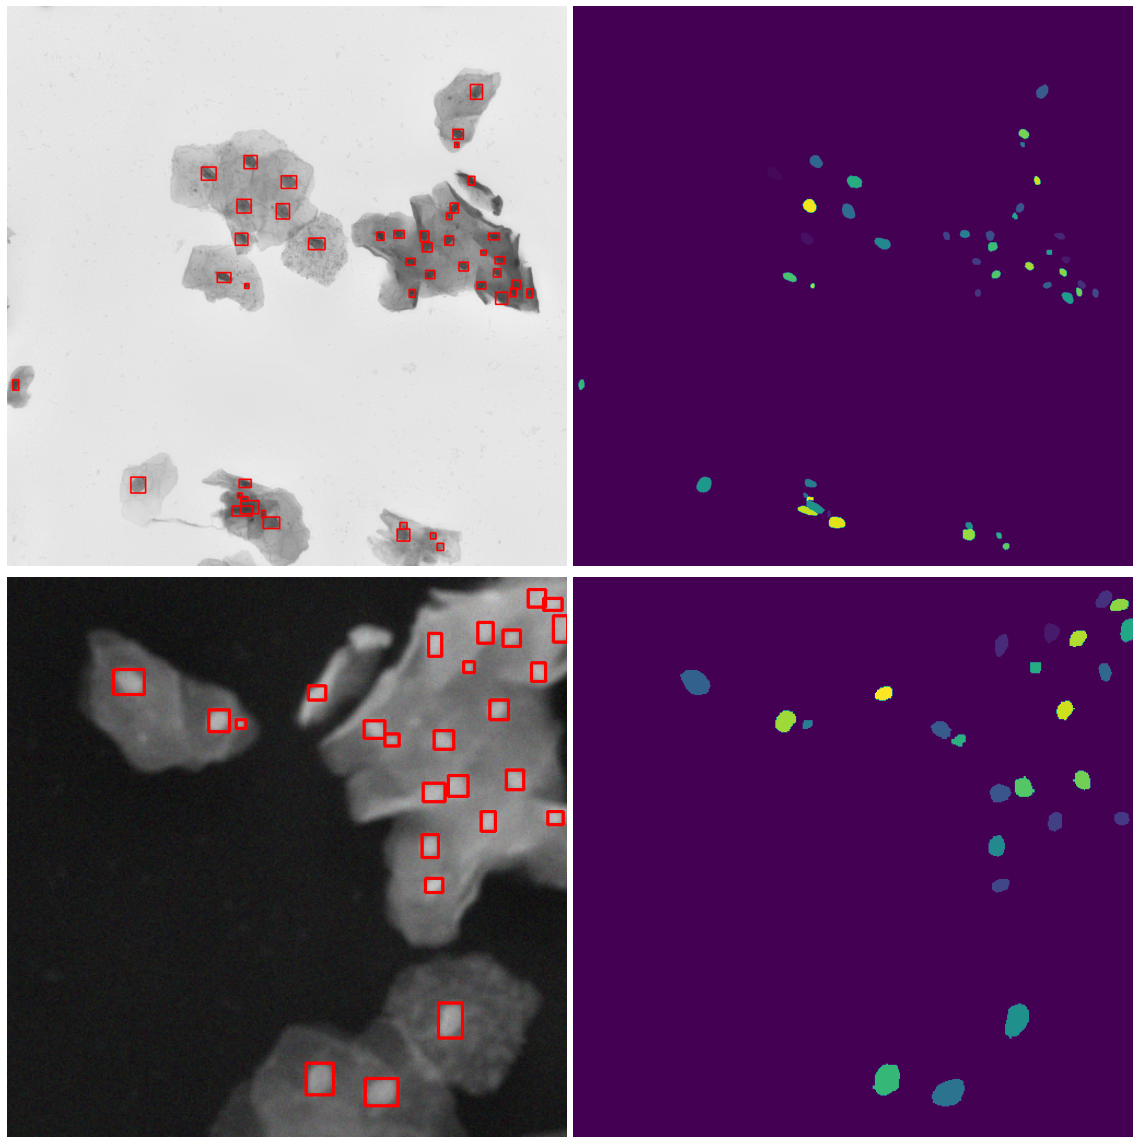

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

for bbox in bboxes:
    visualize_bbox(image, bbox)
axs[0, 0].imshow(image)
axs[0, 0].axis('off')

axs[0, 1].imshow(label_image)
axs[0, 1].axis('off')

for bbox in t_bboxes:
    visualize_bbox(t_image, bbox)
axs[1, 0].imshow(t_image)
axs[1, 0].axis('off')

axs[1, 1].imshow(t_label_image)
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()